In [1]:
import pandas as pd
import numpy as np
from os import path

In [2]:
codes, uniques = pd.factorize(['b', 'b', 'a', 'c', 'b'])
display(codes)
display(uniques)

array([0, 0, 1, 2, 0])

array(['b', 'a', 'c'], dtype=object)

In [3]:
codes, uniques = pd.factorize(['a', 'b', 'b', 'c', 'b'])
display(codes)
display(uniques)

array([0, 1, 1, 2, 1])

array(['a', 'b', 'c'], dtype=object)

### Load the data

In [4]:
train_file = "Task3a_training.csv"
test_file = "Task3a_testing.csv"

data_rel_path = "../../data/raw"

train_df = pd.read_csv(path.join(data_rel_path, train_file))
test_df = pd.read_csv(path.join(data_rel_path, test_file))

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   public_id   900 non-null    object
 1   text        900 non-null    object
 2   title       884 non-null    object
 3   our rating  900 non-null    object
dtypes: object(4)
memory usage: 28.2+ KB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   public_id   364 non-null    object
 1   text        364 non-null    object
 2   title       357 non-null    object
 3   our rating  364 non-null    object
dtypes: object(4)
memory usage: 11.5+ KB


### Rename columns

In [7]:
train_df.rename(columns={'public_id': 'id', "our rating": "rating"}, inplace=True)
test_df.rename(columns={'public_id': 'id', "our rating": "rating"}, inplace=True)

### Drop rows with null values

In [8]:
# train_df.dropna(inplace=True)
# test_df.dropna(inplace=True)

### Set `rating` values to lower case

In [9]:
train_df['rating'] = train_df['rating'].str.lower()
test_df['rating'] = test_df['rating'].str.lower()

### Visualisation de la distribution de classes

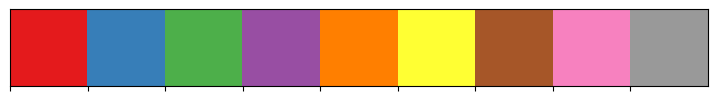

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Here we have a list of the color palettes: https://www.codecademy.com/article/seaborn-design-ii
# Another reference: https://medium.com/@morganjonesartist/color-guide-to-seaborn-palettes-da849406d44f
palette = sns.color_palette('Set1')
sns.palplot(palette)

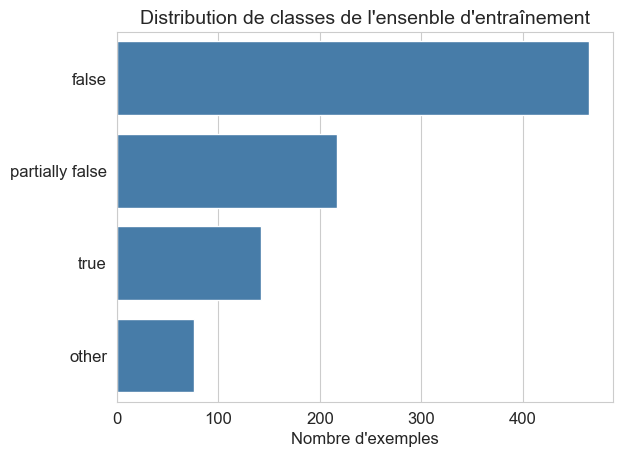

In [11]:
sns.set_style('whitegrid')
ax: 'plt.Axes' = sns.barplot(x=train_df['rating'].value_counts(), y=train_df['rating'].value_counts().index, orient='h', color=palette[1])
_ = ax.set_title("Distribution de classes de l'ensenble d'entraînement", size=14)
_ = ax.set_xlabel("Nombre d'exemples", fontsize=12)
ax.tick_params(axis='both', labelsize=12)
plt.show()

### Add text length
Here we add a column to compute the length of the text and title for each example.

BERT accepts an input of 512 tokens, everything else will be discarded. So, we want to have a column to check how many examples contain text (content and title) that are bigger than that. This information might or might not be used for our purposes. We could try different strategies like using the beginning, somewhere in the middle or the end of the texts.

In [12]:
def add_len_columns(df: 'pd.DataFrame'):
    """
    The input DF must contain a `'text'` and `'title'` columns.
    """
    df['text_len'] = df['text'].str.len()
    df['title_len'] = df['title'].str.len()

add_len_columns(train_df)
add_len_columns(test_df)

### How many examples have a length greater than 512?
**NOTE: this will not correspond to the actual tokens, since tokens are not a 1-to-1 relationships at word level. Some words could be represented by 1 or more tokens. It's just to have an vague idea.**

In [13]:
print("Examples whose content's lenght is greater than 512")
print("train_df ", ((train_df['text_len'] > 512).sum() / train_df.shape[0]) * 100)
print("test_df  ", ((test_df['text_len'] > 512).sum() / test_df.shape[0]) * 100)
print()
print("Examples whose title's lenght is greater than 512")
print("train_df ", ((train_df['title_len'] > 512).sum() / train_df.shape[0]) * 100)
print("test_df  ", ((test_df['title_len'] > 512).sum() / test_df.shape[0]) * 100)

Examples whose content's lenght is greater than 512
train_df  94.44444444444444
test_df   93.95604395604396

Examples whose title's lenght is greater than 512
train_df  5.222222222222222
test_df   3.8461538461538463


**Basically, all fo the content will be truncated. Maybe we need to test different strategies.**

### Duplicated values by column

In [14]:
def duplicates_by_col(df: 'pd.DataFrame'):
    dups = dict()
    for col in ['id', 'text', 'title']:
        dups[col] = df[df[col].duplicated(keep=False)]
    return dups

train_df_dups = duplicates_by_col(train_df)
test_df_dups = duplicates_by_col(test_df)

In [15]:
print("Duplicated values")

def print_num_duplicates(dups: 'dict'):
    for col in dups.keys():
        print(f"{col}: {dups[col].shape[0]}")

print("train_df. Num of duplicates")
print_num_duplicates(train_df_dups)
print()
print("test_df. Num of duplicates")
print_num_duplicates(test_df_dups)

Duplicated values
train_df. Num of duplicates
id: 0
text: 33
title: 43

test_df. Num of duplicates
id: 0
text: 19
title: 28


##### **NOTE**: we found a few duplicates. In some cases we have a different text, but also we could have a different rating. This last case could be problematic during training. This duplication problem also applies to the test data set. Below we explore this duplicates.

In [17]:
with pd.option_context('display.max_rows', 30,
                       'display.max_colwidth', 90,
                       ):
    print("Training set")
    print("--------------")
    print()
    print("Title duplicates")
    display(train_df_dups['title'])
    print()
    print("Text duplicates")
    display(train_df_dups['text'])

Training set
--------------

Title duplicates


id  \
12   c69de08e   
22   213a870b   
72   71986c29   
80   bb1342bc   
94   cbb6ee95   
..        ...   
868  b099e01c   
879  bf3f6fdb   
887  81a67c96   
891  866a5b6b   
898  842ac903   

                                                                                          text  \
12   The proportion of people living in poverty who are in a working family has hit a recor...   
22   Have an important tip? Let us know. Email us here.  Keep up to date with our latest:  ...   
72   By Jim Francesconi  As we pass the governance torch from the State Board of Higher Edu...   
80   People with lung cancer are dying after being diagnosed late in A&E because their GP m...   
94   Equally troubling was the more recent discovery by Tom Fitz, a geology professor at No...   
..                                                                                         ...   
868  The worst murderers should be given a chance to escape staying in prison for life by p...   
879  MOSCOW, August 13. /TASS/. The United States’ intention to take sanctions against Russ...   
887  Former state House Majority Leader Adam Hasner, now running in a crowded Republican pr...   
891  Beaumont, Texas | An employee of the Jefferson County morgue died this morning after b...   
898  Rep. Leon Young figures the Wisconsin Legislature already works just part-time. So may...   

                                                                                         title  \
12                            Number of people in poverty in working families hits record high   
22   Smoking Gun! Joe Biden’s Dept. of Energy Blocked Texas from Increasing Power Ahead of ...   
72                         Tapping private resources for public university good: Guest opinion   
80                             Late diagnosis of lung cancer hitting survival rate, study says   
94                                         The Fight for Wisconsin’s Soul - The New York Times   
..                                                                                         ...   
868                        Tapping private resources for public university good: Guest opinion   
879                                                                                        NaN   
887                                                                      - The Washington Post   
891                                                Capitol Shooting Exposed as Hollywood Stunt   
898                                                                                        NaN   

              rating  text_len  title_len  
12             false      4414       64.0  
22             false      2706       98.0  
72   partially false      3946       67.0  
80             false      3642       63.0  
94   partially false      3954       51.0  
..               ...       ...        ...  
868            false      5015       67.0  
879  partially false      2257        NaN  
887  partially false      2106       21.0  
891            false      1361       43.0  
898            false      3093        NaN  

[43 rows x 6 columns]


Text duplicates


id  \
12   c69de08e   
94   cbb6ee95   
95   28a5ba2e   
133  fd445807   
206  f43a6abc   
..        ...   
712  3a802a26   
755  37766490   
821  70d7c3f7   
858  6600699c   
863  6378a0ff   

                                                                                          text  \
12   The proportion of people living in poverty who are in a working family has hit a recor...   
94   Equally troubling was the more recent discovery by Tom Fitz, a geology professor at No...   
95   The proportion of people living in poverty who are in a working family has hit a recor...   
133  In stunning new findings released by the Dunning-Kruger Institute, Democrats were foun...   
206  It has long been established that Democrats cheat in order to win elections. They have...   
..                                                                                         ...   
712  ADVERTISEMENT The fire that gutted a flank of the Treasury House, office of the Accoun...   
755  PM to set out his vision for a “truly twenty-first century” prison system, while calli...   
821  ADVERTISEMENT The fire that gutted a flank of the Treasury House, office of the Accoun...   
858  Jonathan Ashworth MP, Labour’s Shadow Health Secretary, will today pledge to introduce...   
863  A coalition of civil society groups has described the proposed Control of Infectious D...   

                                                                                         title  \
12                            Number of people in poverty in working families hits record high   
94                                         The Fight for Wisconsin’s Soul - The New York Times   
95                            Number of people in poverty in working families hits record high   
133                Democrats Tried to Slip a Law Banning Pledge of Allegiance Into Aid Package   
206           Pelosi Wants To Remove Votes From Soldiers Overseas: ‘They Don’t Even Live Here’   
..                                                                                         ...   
712                                        How fire gutted Nigeria’s Treasury House — Minister   
755  Democrat Fundraising Machine ‘ActBlue Texas’ Caught Paying Out Small Sums to Hundreds ...   
821                     Trudeau Bought His Mother A Car Using WE Charity Funds – Conservative…   
858                              Up to a third of millennials 'face renting their entire life'   
863                                                                                        NaN   

              rating  text_len  title_len  
12             false      4414       64.0  
94   partially false      3954       51.0  
95             false      4414       64.0  
133            false      1441       75.0  
206            false      1948       80.0  
..               ...       ...        ...  
712             true      2171       51.0  
755             true      5846      139.0  
821             true      2171       70.0  
858             true      4372       61.0  
863             true      4085        NaN  

[33 rows x 6 columns]

In [18]:
with pd.option_context('display.max_rows', 30,
                       'display.max_colwidth', 90,
                       ):
    print("Testing set")
    print("--------------")
    print("Title duplicates")
    display(test_df_dups['title'])
    print()
    print("Text duplicates")
    display(test_df_dups['text'])


Testing set
--------------
Title duplicates


id  \
23   842ac903   
44   53d111d0   
88   17717174   
100  42b5592a   
121  5a2459c3   
122  10cfd37c   
125  bf3f6fdb   
137  fe823860   
138  6378a0ff   
186  24fd8f3f   
214  cf0ae5c6   
217  7212bc8a   
225  44d974ca   
236  cd7aee72   
241  ad9a9514   
245  79e725b3   
251  eda82986   
287  acc4517a   
354  1a46b040   
355  c1e124d5   
356  8209ca7b   
357  e2abfbe6   
358  39f5c37f   
359  47423bb6   
360  097c142a   
361  08bc59f4   
362  af3393ce   
363  a39d07df   

                                                                                          text  \
23   Rep. Leon Young figures the Wisconsin Legislature already works just part-time. So may...   
44   The primary school population in England has continued to rise sharply, with 94,000 ex...   
88   Elisa Granato, the first volunteer who availed herself in Oxford for a jab in the firs...   
100  Proctor, VT — According to NBC News, a pastor at the Christian Proctor Church in Vermo...   
121  A measure to limit Florida school board member terms has gained the support of the two...   
122  HON. STEFAN I. MYCHAJLIW ERIE COUNTY COMPTROLLER’S OFFICE DIVISION OF AUDIT & CONTROL ...   
125  MOSCOW, August 13. /TASS/. The United States’ intention to take sanctions against Russ...   
137  In the last year, the Reserve Bank of India bought 8.6 metric tons of goal, its first ...   
138  A coalition of civil society groups has described the proposed Control of Infectious D...   
186  Howl, beat your head against the wall, tear your hair and despair of this country. How...   
214  The average convicted criminal serving a short prison sentence has previously carried ...   
217  The Labour Party has accused the Government of failing patients after the Chancellor b...   
225  The announcement follows the publication of a report by the Mental Health Taskforce, c...   
236  More than four million calls to the taxman are going unanswered, new figures show, as ...   
241  More under-18s are being taken to court for selling cannabis, with prosecutions up by ...   
245  The Government’s much vaunted Help to Buy Isa was on Friday described as a “scandal” a...   
251  The late Robin Williams once called cocaine “God’s way of telling you you’re making to...   
287  It was an accurate and judicious answer, so naturally it sent climate alarmists into p...   
354  Howl, beat your head against the wall, tear your hair and despair of this country. How...   
355  People with lung cancer are dying after being diagnosed late in A&E because their GP m...   
356  The average convicted criminal serving a short prison sentence has previously carried ...   
357  The Labour Party has accused the Government of failing patients after the Chancellor b...   
358  The announcement follows the publication of a report by the Mental Health Taskforce, c...   
359  More than four million calls to the taxman are going unanswered, new figures show, as ...   
360  More under-18s are being taken to court for selling cannabis, with prosecutions up by ...   
361  The Government’s much vaunted Help to Buy Isa was on Friday described as a “scandal” a...   
362  The late Robin Williams once called cocaine “God’s way of telling you you’re making to...   
363  The late Robin Williams once called cocaine “God’s way of telling you you’re making to...   

                                                                                         title  \
23                                                                                         NaN   
44                                                                                         NaN   
88                                                                                         NaN   
100          Why are climate-change models so flawed? Because climate science is so incomplete   
121                            Late diagnosis of lung cancer hitting survival rate, study says   
122                                                                                   


Text duplicates


id  \
107  168e5898   
186  24fd8f3f   
214  cf0ae5c6   
217  7212bc8a   
225  44d974ca   
236  cd7aee72   
241  ad9a9514   
245  79e725b3   
251  eda82986   
350  6c425155   
354  1a46b040   
356  8209ca7b   
357  e2abfbe6   
358  39f5c37f   
359  47423bb6   
360  097c142a   
361  08bc59f4   
362  af3393ce   
363  a39d07df   

                                                                                          text  \
107  Increased atmospheric carbon dioxide has helped raise global food production and reduc...   
186  Howl, beat your head against the wall, tear your hair and despair of this country. How...   
214  The average convicted criminal serving a short prison sentence has previously carried ...   
217  The Labour Party has accused the Government of failing patients after the Chancellor b...   
225  The announcement follows the publication of a report by the Mental Health Taskforce, c...   
236  More than four million calls to the taxman are going unanswered, new figures show, as ...   
241  More under-18s are being taken to court for selling cannabis, with prosecutions up by ...   
245  The Government’s much vaunted Help to Buy Isa was on Friday described as a “scandal” a...   
251  The late Robin Williams once called cocaine “God’s way of telling you you’re making to...   
350  Increased atmospheric carbon dioxide has helped raise global food production and reduc...   
354  Howl, beat your head against the wall, tear your hair and despair of this country. How...   
356  The average convicted criminal serving a short prison sentence has previously carried ...   
357  The Labour Party has accused the Government of failing patients after the Chancellor b...   
358  The announcement follows the publication of a report by the Mental Health Taskforce, c...   
359  More than four million calls to the taxman are going unanswered, new figures show, as ...   
360  More under-18s are being taken to court for selling cannabis, with prosecutions up by ...   
361  The Government’s much vaunted Help to Buy Isa was on Friday described as a “scandal” a...   
362  The late Robin Williams once called cocaine “God’s way of telling you you’re making to...   
363  The late Robin Williams once called cocaine “God’s way of telling you you’re making to...   

                                                                                         title  \
107                              NHS fails thousands of new mothers with post-natal depression   
186  It's heartless to blame job losses on unemployed people – but it's how much of Britain...   
214  Average criminal given a short prison sentence has already committed more than 55 offe...   
217  Chancellor failing patients with his £30 billion NHS cut as waiting lists hit record high   
225                                                   New investment in mental health services   
236  Taxman fails to answer four million calls a year, as MPs warn people are not getting t...   
241                                         Police catch 11‑year‑olds being used to sell drugs   
245  Help to Buy Isa scandal: 500,000 first-time buyers told scheme cannot be used for init...   
251                                                   A coke-snorting generation of hypocrites   
350                                                                The Phony War Against CO2\n   
354  It's heartless to blame job losses on unemployed people – but it's how much of Britain...   
356  Average criminal given a short prison sentence has already committed more than 55 offe...   
357  Chancellor failing patients with his £30 billion NHS cut as waiting lists hit record high   
358                                                   New investment in mental health services   
359  Taxman fails to answer four million calls a year, as MPs warn people are not getting t...   
360                                         Police catch 11‑year‑olds being used to sell drugs   
361  Help to Buy Isa scandal: 500,000 first

### Export duplicates to xlsx

In [19]:
# import os

def export_to_excel(filename: 'str', dup_dict: 'dict'):
    # if path.exists(filename) and overwrite:
    #     os.remove(filename)
    
    with pd.ExcelWriter(filename) as writer:
        # Save duplicates grouped by title and text
        dup_dict['title'].groupby('title', group_keys=True).apply(lambda x: x).to_excel(writer, sheet_name='title_dups')
        dup_dict['text'].groupby('text', group_keys=True).apply(lambda x: x).to_excel(writer, sheet_name='text_dups')


# # Save duplicates grouped by title and text
# train_df_dups['title'].groupby('title', group_keys=True).apply(lambda x: x).to_excel('train_title_dups.xlsx')
# train_df_dups['text'].groupby('text', group_keys=True).apply(lambda x: x).to_excel('train_text_dups.xlsx')

# # Save duplicates grouped by title and text
# valid_df_dups['title'].groupby('title', group_keys=True).apply(lambda x: x).to_excel('valid_title_dups.xlsx')
# valid_df_dups['text'].groupby('text', group_keys=True).apply(lambda x: x).to_excel('valid_text_dups.xlsx')

# # Save duplicates grouped by title and text
# test_df_dups['title'].groupby('title', group_keys=True).apply(lambda x: x).to_excel('test_title_dups.xlsx')
# test_df_dups['text'].groupby('text', group_keys=True).apply(lambda x: x).to_excel('test_text_dups.xlsx')

export_to_excel('train_dups.xlsx', train_df_dups)
export_to_excel('test_dups.xlsx', test_df_dups)


### Remove duplicates (considering `text` and `title` only)

In [20]:
train_uniques = train_df.drop_duplicates(subset=['title']).drop_duplicates(subset=['text'])
test_uniques = test_df.drop_duplicates(subset=['title']).drop_duplicates(subset=['text'])

Number of examples in each dataset after deleting duplicates

In [21]:
print(f"Train dataset: {train_df.shape[0]}")
print(f"Train uniques: {train_uniques.shape[0]}")
print(f"Test dataset:  {test_df.shape[0]}")
print(f"Test uniques:  {test_uniques.shape[0]}")

Train dataset: 900
Train uniques: 861
Test dataset:  364
Test uniques:  346


### Values in labels

In [22]:
train_df['rating'].value_counts()

false              465
partially false    217
true               142
other               76
Name: rating, dtype: int64

In [23]:
test_df['rating'].value_counts()

partially false    141
false              113
true                69
other               41
Name: rating, dtype: int64